# FFT and IFFT filtering of TEM image stacks

By Meng Li
20230630


In [2]:
import insitu_IO as IO
import numpy as np
import insitu_Preprocess as PP
import cv2
import tqdm
import tifffile
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# path ='/Volumes/Extreme Pro/CuNi paper/Cu5Ni F5S2-26.mp4'
path=input('Input tiff stack path name:')

#path='test.mp4'
# pathout = path[:-4]+'_DB.tif'
Scale = 35 #new camera 1000kX


Input mp4 path name:/Volumes/One Touch/Experiment data/ECC/WO3/20230623 WO3 in situ/!Pt WO3-11-H2 intercalation_X20_DB_TF.tif


In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import tifffile #package that supports tiff file >4G
import easygui
import tqdm
import insitu_IO as IO

stack =tifffile.imread(path)

nFrames, h,w = stack.shape

print(stack.shape)

(130, 1854, 1856)


1854


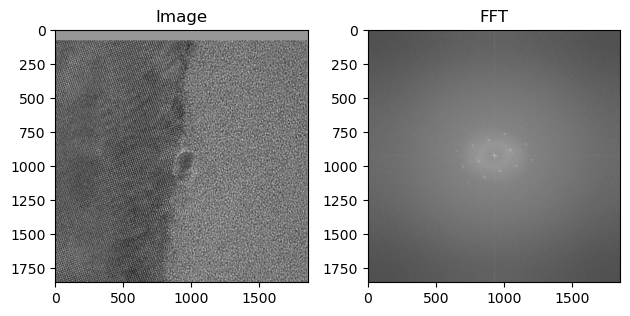

In [7]:
#test on one frame
i=2
# Load HRTEM image (replace 'image_path' with the actual path to your image file)
image = stack[i]


if h !=w:
    d=min(h,w)
    image=image[0:d,0:d]
    print(d)
    
# Perform FFT
fft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
fft_shifted = np.fft.fftshift(fft)
# fft = np.fft.fftshift(np.fft.fft2(image))

# Compute the power spectrum
# power_spectrum = np.abs(fft) ** 2
# fftimg=np.log10(power_spectrum)
fftimg=np.log(1 + cv2.magnitude(fft_shifted[:, :, 0], fft_shifted[:, :, 1]))

# Display the HRTEM image
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Image')

# Display the power spectrum
plt.subplot(1, 2, 2)
plt.imshow(fftimg, cmap='gray')
plt.title('FFT')

# Adjust subplot spacing
plt.tight_layout()

# Show the plots
plt.show()

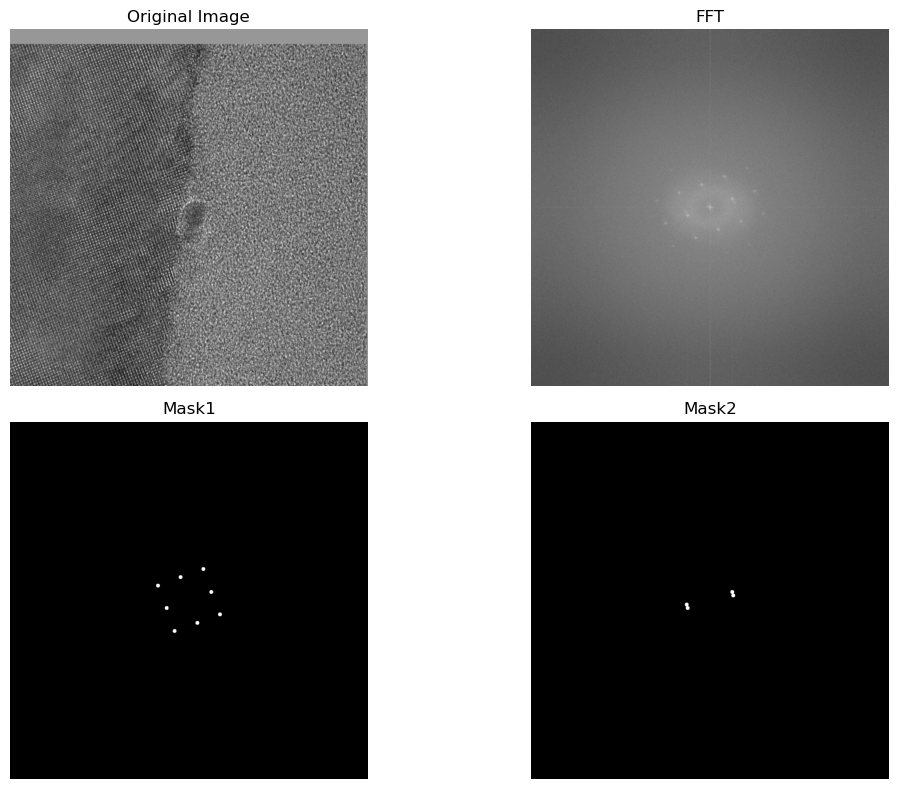

In [10]:
import math

#generate mask for FFT

#The following parameters are measured from FIJI, where the FFT is automatically rescaled to next 2^n, ie. 2048 

# Spot of original lattice
d1=278; #spot of DP WO3(200)
d2=271;#Spot of DP WO3(020)
d31=391;#Spot of DP WO3(220)
d32=391;#spot of   DP WO3(2-20)

a1=-69.9; #Angle of the DP WO3 (200)
a2=-160.3;#Angle of DP WO3 (020) 
a31=-24.9;
a32=-114.9;


# ////Spot of distortion lattice
# //d1=278; //spot of DP WO3(200)
d22=293; #Spot of DP WO3(020)
# //d32=362;//Spot of DP WO3(220)
# //d31=440;//spot of strips near DP WO3(200)
# //
# //a1=-69.9;//Angle of the DP WO3 (200)
a22=11.2;#Angle of DP WO3 (020) 
# //a31=-28.9;
# //a32=-121.8;



radius=10 #radius of masked spots
color=255 #white
sigmaX=int(radius/4)

scale=d/2048

# Create a black mask image
mask = np.zeros((d, d), dtype=np.uint8)
mask2 = np.zeros((d, d), dtype=np.uint8)

# Draw circles on the mask image

# cv2.circle(mask, (Cx, Cy), radius, color, -1)

def maskDP(d,angle,mask,n_points=1,radius=20):
    """
    function to get coordinates of FFT mask:
    d: measured paired d-spacing in FFT
    angle: measured angle of the FFT pair
    n_point: number of points in the mask
    Cx,Cy: center of the FFT image
    """
    import math
    angle_rad=math.radians(-angle)
    w,h=mask.shape
    n = math.ceil(math.log2(w))
    pad=2**n

    scale=w/pad
    d=d*scale
    Cx=w/2
    Cy=h/2
    

    for j in range(n_points):
        x1=int(Cx+d*math.cos(angle_rad)*(j+1)/2)
        y1=int(Cy+d*math.sin(angle_rad)*(j+1)/2)
        cv2.circle(mask, (x1, y1), radius, 255, -1)

        x2=int(Cx-d/2*math.cos(angle_rad)*(j+1))
        y2=int(Cy-d/2*math.sin(angle_rad)*(j+1))
        cv2.circle(mask, (x2, y2), radius, 255, -1)
        
#     return X,Y




#mask1: crystalline spots        
maskDP(d1,a1,mask,n_points=1,radius=radius)
maskDP(d2,a2,mask,n_points=1,radius=radius)
maskDP(d31,a31,mask,n_points=1,radius=radius)
maskDP(d32,a32,mask,n_points=1,radius=radius)

#mask2: strips
maskDP(d2,a2,mask2,n_points=1,radius=radius)
maskDP(d2,a22,mask2,n_points=1,radius=radius)


# Apply Gaussian blur to the circles
# mask = cv2.GaussianBlur(mask, (0, 0), sigmaX)

# Perform FFT on the image
fft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
fft_shifted = np.fft.fftshift(fft)

# Display the images
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(222)
plt.title('FFT')
plt.imshow(np.log(1 + cv2.magnitude(fft_shifted[:, :, 0], fft_shifted[:, :, 1])), cmap='gray')
plt.axis('off')

plt.subplot(223)
plt.title('Mask1')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(224)
plt.title('Mask2')
plt.imshow(mask2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


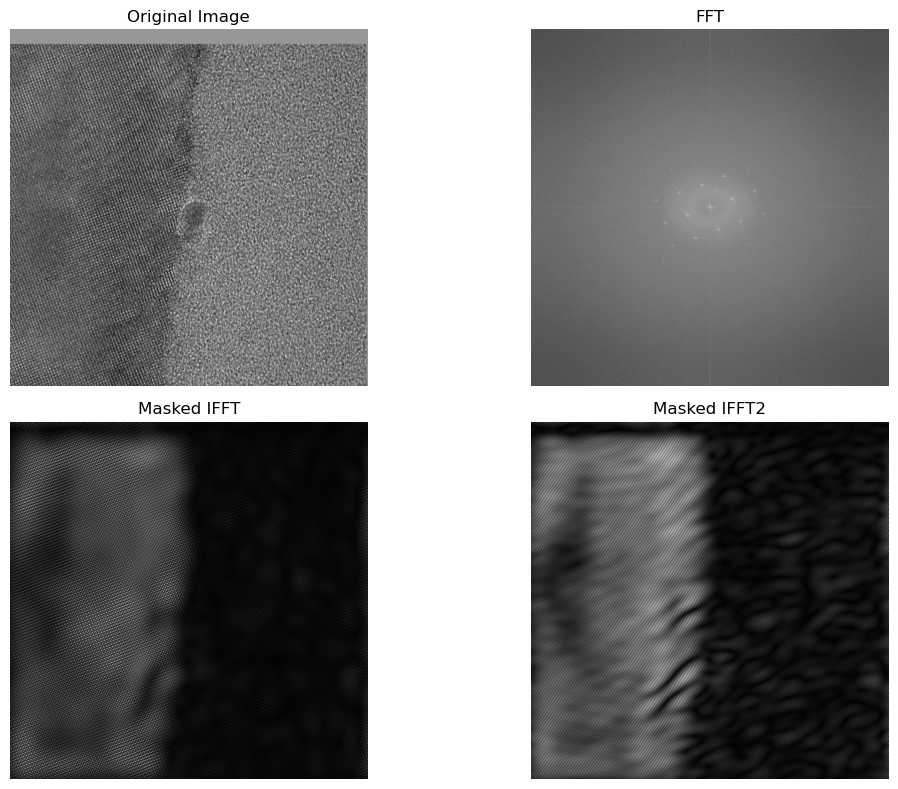

In [11]:

def maskedFFT(image,mask):
    """
    generate masked image from FFT
    Input: original image; mask
    Output: FFT_image, filtered IFFT image
    """
    h,w=image.shape

    if h !=w:
        d=min(h,w)
        image=image[0:d,0:d]

    # Perform FFT on the image
    fft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    fft_shifted = np.fft.fftshift(fft)
    fft_image=np.log(1 + cv2.magnitude(fft_shifted[:, :, 0], fft_shifted[:, :, 1]))
    

    # Ensure the mask image has the same size as the FFT
    mask_image = cv2.resize(mask,(fft_shifted.shape[1], fft_shifted.shape[0]))

    # Apply the mask to the FFT
    masked_fft_shifted = cv2.bitwise_and(fft_shifted, fft_shifted, mask=mask_image)


    # Perform inverse FFT on the masked FFT
    masked_fft = np.fft.ifftshift(masked_fft_shifted)
    masked_image = cv2.idft(masked_fft)
    masked_image = cv2.magnitude(masked_image[:, :, 0], masked_image[:, :, 1])
    
    #convert to 8bit images
    fft_image=cv2.normalize(fft_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    masked_image=cv2.normalize(masked_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    return fft_image, masked_image



fft_image, masked_image = maskedFFT(image,mask)
fft_image2, masked_image2 = maskedFFT(image,mask2)



# Display the images
plt.figure(figsize=(12, 8))

# plt.subplot(221)
# plt.title('Original Image')
# plt.imshow(image, cmap='gray')
# plt.axis('off')

# plt.subplot(222)
# plt.title('FFT')
# plt.imshow(np.log(1 + cv2.magnitude(fft_shifted[:, :, 0], fft_shifted[:, :, 1])), cmap='gray')
# plt.axis('off')

# plt.subplot(223)
# plt.title('Masked FFT')
# plt.imshow(np.log(1 + cv2.magnitude(masked_fft_shifted[:, :, 0], masked_fft_shifted[:, :, 1])), cmap='gray')
# plt.axis('off')

# plt.subplot(224)
# plt.title('Masked IFFT')
# plt.imshow(masked_image, cmap='gray')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

plt.subplot(221)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(222)
plt.title('FFT')
plt.imshow(fft_image, cmap='gray')
plt.axis('off')

plt.subplot(223)
plt.title('Masked IFFT')
plt.imshow(masked_image, cmap='gray')
plt.axis('off')

plt.subplot(224)
plt.title('Masked IFFT2')
plt.imshow(masked_image2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


# # Display the black mask image
# # cv2.imshow("Black Mask Image", mask)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
# plt.subplot(1, 2, 1)
# plt.imshow(mask, cmap='gray')
# plt.title('Mask')

# # Display the power spectrum
# plt.subplot(1, 2, 2)
# plt.imshow(np.log(1 + cv2.magnitude(masked_fft_shifted[:, :, 0], masked_fft_shifted[:, :, 1])), cmap='gray')

# # plt.imshow(masked_fft_shifted, cmap='gray')
# plt.title('Masked FFT')

In [50]:
# Convert format and Apply IFFT to original image, the input masked_image need to be un-normalized
fft_img=np.log(1 + cv2.magnitude(fft_shifted[:, :, 0], fft_shifted[:, :, 1]))
fft_img = cv2.normalize(fft_img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

print('Image data type:', fft_img.dtype)

# Verify image values
print('Min pixel value:', fft_img.min())
print('Max pixel value:', fft_img.max())

# # Normalize the pixel values to the range of 0-255
masked_image_8 = cv2.normalize(masked_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

scale=0.3

masked_image_normalized = cv2.normalize(masked_image, None, 0, int(255*scale), cv2.NORM_MINMAX, cv2.CV_8U)
image_normalized = cv2.normalize(image, None, 0, int(255*(1-scale*0.5)), cv2.NORM_MINMAX, cv2.CV_8U)


IO.showFr(fft_img)

IO.showFr(masked_image_normalized)

filtered_image=cv2.add(image_normalized,masked_image_normalized)

IO.showFr(filtered_image)

# result_8 = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# IO.showFr(result_8)

Image data type: uint8
Min pixel value: 0
Max pixel value: 255


In [12]:
#Apply to stack

pathFFT=path[:-4]+'_FFT.tif'
pathIFFT=path[:-4]+'_IFFT.tif'
pathIFFT2=path[:-4]+'_IFFT2.tif'
print("------------------------------------------")
print("Saving output frames~")   
with tifffile.TiffWriter(pathFFT,bigtiff=True) as tif, tifffile.TiffWriter(pathIFFT,bigtiff=True) as tif2,tifffile.TiffWriter(pathIFFT2,bigtiff=True) as tif3:
    for i in tqdm.tqdm(range(nFrames)):
        image = stack[i]
        fft_image, masked_image = maskedFFT(image,mask)
        fft_image2, masked_image2 = maskedFFT(image,mask2)

#         if h !=w:
#             d=min(h,w)
#             image=image[0:d,0:d]
#         # Perform FFT on the image
#         fft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
#         fft_shifted = np.fft.fftshift(fft)
#         # Ensure the mask image has the same size as the FFT
#         mask_image = cv2.resize(mask_image, (fft_shifted.shape[1], fft_shifted.shape[0]))
#         # Apply the mask to the FFT
#         masked_fft_shifted = cv2.bitwise_and(fft_shifted, fft_shifted, mask=mask_image)
#         # Perform inverse FFT on the masked FFT
#         masked_fft = np.fft.ifftshift(masked_fft_shifted)
#         masked_image = cv2.idft(masked_fft)
#         masked_image = cv2.magnitude(masked_image[:, :, 0], masked_image[:, :, 1])
#         #save images
#         fft_img = np.log(1 + cv2.magnitude(fft_shifted[:, :, 0], fft_shifted[:, :, 1]))
#         fft_img_8 = cv2.normalize(fft_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
#         masked_image_8 = cv2.normalize(masked_image, None, 0, int(255*scale), cv2.NORM_MINMAX, cv2.CV_8U)
#         masked_image_82 = cv2.normalize(masked_image2, None, 0, int(255*scale), cv2.NORM_MINMAX, cv2.CV_8U)

        tif.write(fft_image, contiguous=True)
        tif2.write(masked_image,contiguous=True)
        tif3.write(masked_image2,contiguous=True)
print("Done!")

    

------------------------------------------
Saving output frames~


100%|█████████████████████████████████████████| 130/130 [03:11<00:00,  1.48s/it]


Input FFT stack path name:/Volumes/One Touch/Experiment data/ECC/WO3/20230623 WO3 in situ/FFT Movie of !Pt WO3-15-O2_X20_DB_TF.tif
FFTimg: uint8
resized_polarFFT: uint8
0 255
116.0 255.0
background_image:  float64
reconstructed_image:  uint8
enhanced_FFT:  uint8


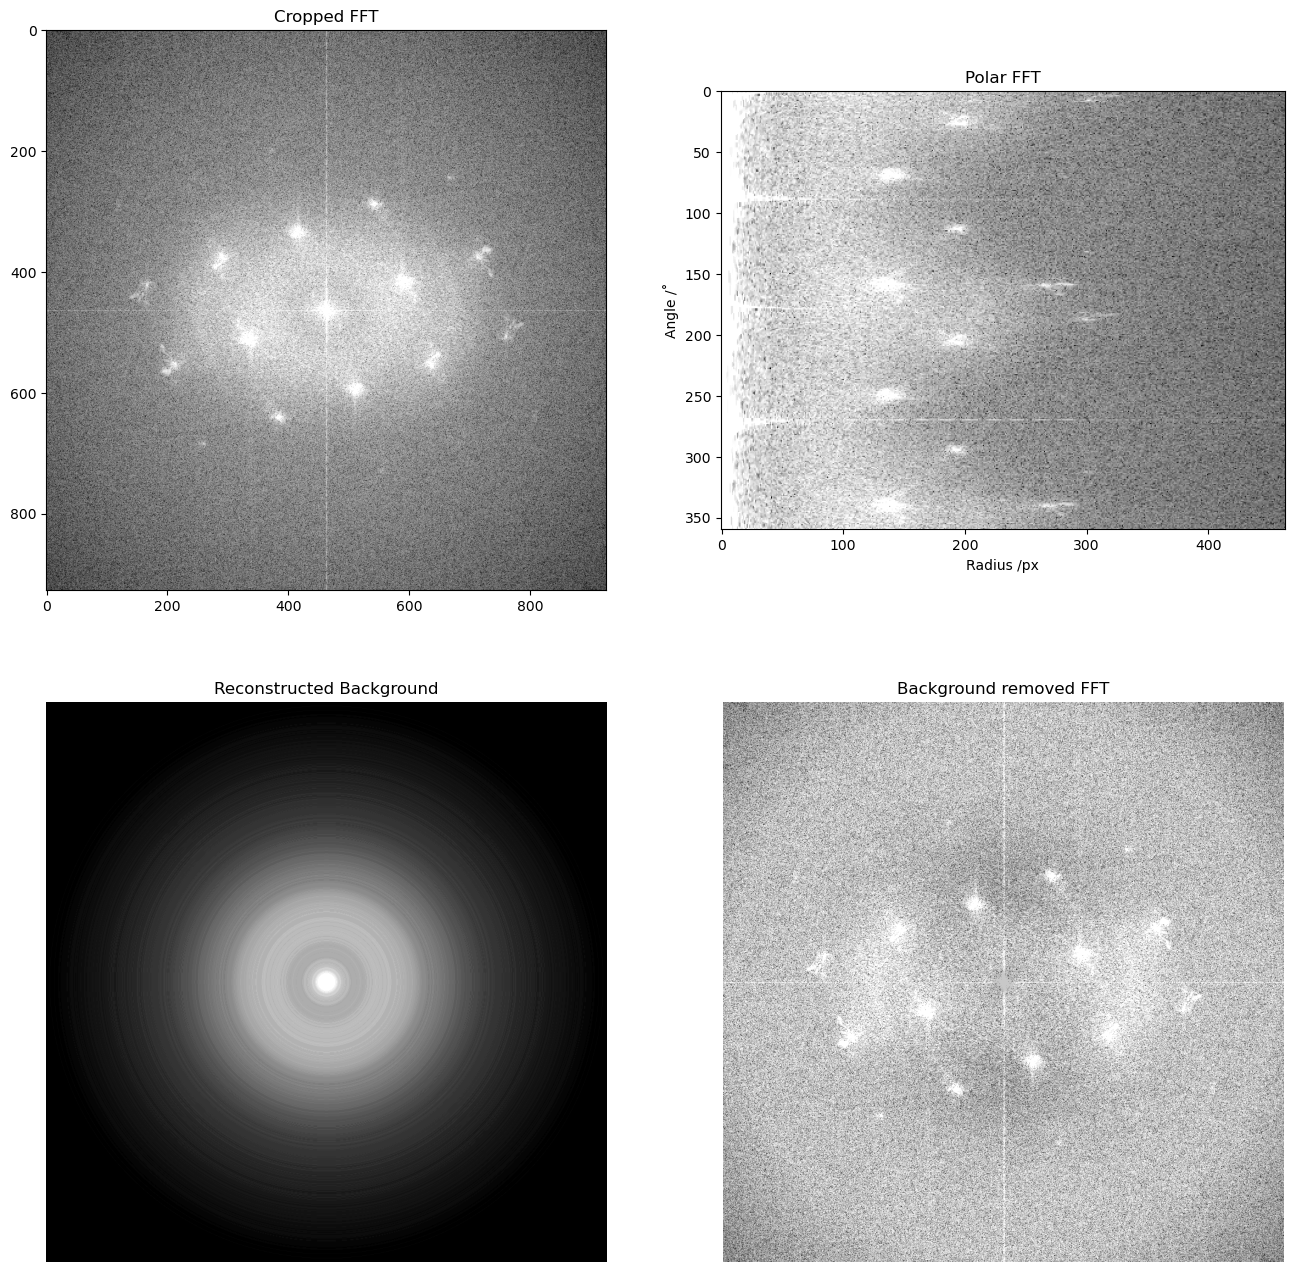

In [556]:
#Enhance signal from FFT

pathFFT=input('Input FFT stack path name:')

fftstack=tifffile.imread(pathFFT)
nFrames,h,w=fftstack.shape


# cutsize=int(h/2)
cutsize=927

i=1
FFTimg=fftstack[i]


def cropcanvas(image,outw,outh):
    h,w=image.shape
    cutx=int((w-outw)//2)
    cuty=int((h-outh)//2)
    return image[cuty:cuty+outh,cutx:cutx+outw]

FFTimg=cropcanvas(FFTimg,cutsize,cutsize)

# FFTimg = np.float64(FFTimg)
# FFTimg = cv2.normalize(FFTimg, None, 0.0, 1.0, cv2.NORM_MINMAX)

print("FFTimg:" ,FFTimg.dtype)

# imageInit=FFTimge

import numpy as np
import cv2
from scipy.signal import tukey, convolve2d
from scipy.interpolate import interp2d
from scipy.ndimage import map_coordinates
from scipy.signal import medfilt


def linear_to_polar(image):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    max_radius = max(center[0], center[1])
#     print(max_radius)
    polar_image = cv2.linearPolar(image, center, max_radius, cv2.WARP_FILL_OUTLIERS)

    return polar_image
#     return polar_image

def polar_to_linear(image):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    max_radius = max(center[0], center[1])
    linear_image = cv2.linearPolar(image, center, max_radius, cv2.WARP_INVERSE_MAP)
    return linear_image


def rotational_average(polar_image):
    num_angles, num_radii = polar_image.shape
    max_radius = num_radii 
    
    rotational_avg = np.zeros(max_radius)
    
    for radius in range(max_radius):
        values = polar_image[:, radius]
        rotational_avg[radius] = np.mean(values)
    
    return rotational_avg

# Convert FFTimg to polar coordinates
polarFFT = linear_to_polar(FFTimg)
new_width=max_radius
new_height=360
resized_polarFFT = cv2.resize(polarFFT, (new_width, new_height))
print("resized_polarFFT:" ,resized_polarFFT.dtype)
Intensity_min=np.min(polarFFT)
Intensity_max=np.max(polarFFT)
print(Intensity_min, Intensity_max)



# Fit the background
background = np.median(polarFFT, axis=0)
# background_normalize = background/255
# background = background.astype(np.uint8)
# print(background)
# background = background.astype(np.uint8)
Intensity_min=min(background)
# Intensity_min=110
Intensity_max=max(background)
print(Intensity_min, Intensity_max)




background_image = np.tile(background, (polarFFT.shape[0], 1))
# background_image =cv2.repeat(background_normalize.reshape(1, -1), FFTimg.shape[0], 1)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.title('Cropped FFT')
plt.imshow(FFTimg, cmap='gray')
# plt.xlabel('Radius /px')
# plt.ylabel('Angle /˚')
# plt.axis('off')


# # Normalize the background to the range [0, 1]
# normalized_background = cv2.normalize(background_image, None, 0.0, 1.0, cv2.NORM_MINMAX)
# # Scale the normalized background to the desired intensity range
# scaled_background = normalized_background * (Intensity_max - Intensity_min) + Intensity_min

# # Convert the scaled background to the integer data type
# background_image = scaled_background.astype(np.uint8)
# # background_image=background_image.astype(np.unit8)
# scaled_background = background_image * (Intensity_max - Intensity_min) + Intensity_min
# # background_image = scaled_background.astype(np.uint8)
# background_image=cv2.normalize(background_image, None,Intensity_min, Intensity_max, cv2.NORM_MINMAX, cv2.CV_8U)
# background_image=cv2.normalize(background_image, None,Intensity_min,Intensity_max, cv2.NORM_MINMAX , cv2.CV_8U)

print("background_image: ",background_image.dtype)


# rot_avg = rotational_average(resized_polarFFT)
# radius_values = np.arange(len(rot_avg))

# # Smooth background by changing rot average to image
# background = np.zeros_like(resized_polarFFT)
# for radius in range(max_radius):
#     background[:,radius]=rot_avg[radius]




## Reshape background_image to match the size of the polar_image
# background_image_resized = cv2.resize(background_image,FFTimg.shape)

# Generate reconstructed image
reconstructed_image = np.zeros_like(FFTimg)
# print(min(background_image),max(background_image))

# print(FFTimg.min,FFTimg.max)

reconstructed_image =polar_to_linear(background_image)


# Find the black pixels (pixels with intensity 0)
black_pixels = (reconstructed_image == 0)

# Fill the black pixels with Intensity_min
reconstructed_image[black_pixels] = Intensity_min
# # IO.showFr(reconstructed_image)

# Normalize the background to the range [0, 1]
normalized_background = cv2.normalize(reconstructed_image, None, 0.0, 1.0, cv2.NORM_MINMAX)
# Scale the normalized background to the desired intensity range
scaled_background = normalized_background * (Intensity_max - Intensity_min) + Intensity_min
reconstructed_image = scaled_background.astype(np.uint8)

# reconstructed_image =reconstructed_image*1.09 
print("reconstructed_image: ",reconstructed_image.dtype)
# # Somehow the output image of reconstructed_image is changing everytime. 

# reconstructed_image=cv2.normalize(reconstructed_image, None,Intensity_min, Intensity_max, cv2.NORM_MINMAX, cv2.CV_8U)
# reconstructed_image=cv2.normalize(reconstructed_image, None,0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# # Find the black pixels (pixels with intensity 0)
# black_pixels = (reconstructed_image == 0)

# # Fill the black pixels with Intensity_min
# reconstructed_image[black_pixels] = Intensity_min
# IO.showFr(reconstructed_image)

enhanced_FFT=FFTimg-reconstructed_image+128
# enhanced_FFT=cv2.normalize(enhanced_FFT, None,0, 255, cv2.NORM_MINMAX, cv2.CV_64F)
# define the alpha and beta
alpha = 1.5 # Contrast control: [1.0-3.0]
beta = 10 # Brightness control:[0-100]

# call convertScaleAbs function
enhanced_FFT = cv2.convertScaleAbs(enhanced_FFT, alpha=alpha, beta=beta)
enhanced_FFT=cv2.normalize(enhanced_FFT, None,0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
print("enhanced_FFT: ",enhanced_FFT.dtype)



# plt.figure(figsize=(12, 12))
# plt.subplot(221)
# plt.title('Cropped FFT')
# plt.imshow(resized_polarFFT, cmap='gray')
# # plt.xlabel('Radius /px')
# # plt.ylabel('Angle /˚')
# # plt.axis('off')

plt.subplot(222)
plt.title('Polar FFT')
# # plt.title('Cropped FFT')
plt.imshow(resized_polarFFT, cmap='gray')
plt.xlabel('Radius /px')
plt.ylabel('Angle /˚')
# plt.plot(rot_avg)
# plt.xlabel('Radius')
# plt.ylabel('Rotational Average')
# plt.title('Rotational Average of Polar Image')

# plt.imshow(filtered, cmap='gray')

plt.subplot(223)
plt.title('Reconstructed Background')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.subplot(224)
plt.title('Background removed FFT')
plt.imshow(enhanced_FFT, cmap='gray')
plt.axis('off')

plt.show()

(-0.5, 926.5, 926.5, -0.5)

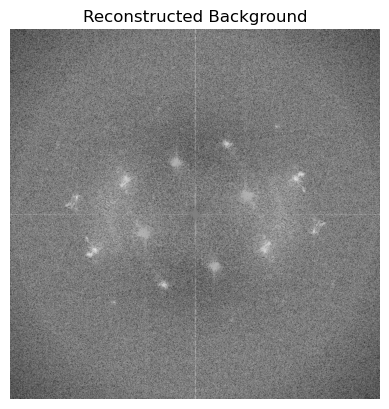

In [557]:
# Create a mask to identify the pixels outside the circle
mask = np.zeros_like(FFTimg, dtype=np.uint8)

# Define the center coordinates and radius of the circle
center = (FFTimg.shape[1] // 2, FFTimg.shape[0] // 2)
radius = FFTimg.shape[1] // 2


cv2.circle(mask, center, radius, 255, -1)  # Fill the circle with white (255)

# Set the intensity of pixels outside the circle to Intensity_min
reconstructed_image[np.where(mask == 0)] = Intensity_min+2
bg=reconstructed_image

enhanced_FFT=FFTimg-bg+128


# Display the modified image
plt.figure()
plt.title('Reconstructed Background')
plt.imshow(enhanced_FFT, cmap='gray')
plt.axis('off')


In [558]:
#Apply to stack

path_polar=pathFFT[:-4]+'_polar.tif'
path_BGr=pathFFT[:-4]+'_BGr.tif'
path_C=pathFFT[:-4]+'_crop.tif'

print("------------------------------------------")
print("Saving output frames~")   
with tifffile.TiffWriter(path_polar,bigtiff=True) as tif, tifffile.TiffWriter(path_BGr,bigtiff=True) as tif2,tifffile.TiffWriter(path_C,bigtiff=True) as tif3:
    for i in tqdm.tqdm(range(nFrames)):
        FFTimg = fftstack[i]
        FFTimg=cropcanvas(FFTimg,cutsize,cutsize)
        
        # Convert FFTimg to polar coordinates
        polarFFT = linear_to_polar(FFTimg)
        new_width=463
        new_height=360
        resized_polarFFT = cv2.resize(polarFFT, (new_width, new_height))
        
        # remove bg of FFT
   
        enhanced_FFT=FFTimg-bg+128
        # define the alpha and beta
        alpha = 1.5 # Contrast control: [1.0-3.0]
        beta = 10 # Brightness control:[0-100]

        # call convertScaleAbs function
        enhanced_FFT = cv2.convertScaleAbs(enhanced_FFT, alpha=alpha, beta=beta)
        enhanced_FFT=cv2.normalize(enhanced_FFT, None,0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        
        tif3.write(FFTimg, contiguous=True)
        tif.write(resized_polarFFT, contiguous=True)
        tif2.write(enhanced_FFT, contiguous=True)


print('Done!')
        

------------------------------------------
Saving output frames~


100%|█████████████████████████████████████████| 152/152 [00:09<00:00, 16.81it/s]


Done!


In [559]:
#Tiff stack to avi
path=path_BGr
# path=input('Input tiff stack path name:')
fps=25
stack =tifffile.imread(path)

nFrames, h,w = stack.shape

outputpath=path[:-4]+'_'+str(fps)+'.avi'

# Create VideoWriter object to save the AVI video
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
video_writer = cv2.VideoWriter(outputpath, fourcc, fps, (width, height),isColor=False)

# Iterate over TIFF stack files and write frames to the video
for i in tqdm.tqdm(range(nFrames)): 
    image = stack[i]
    video_writer.write(image)

# Release the video writer
video_writer.release()

# Print a message when the video creation is finished
print("Video creation finished.")


100%|█████████████████████████████████████████| 152/152 [00:05<00:00, 28.62it/s]


Video creation finished.


AttributeError: 'numpy.ndarray' object has no attribute 'get_array'

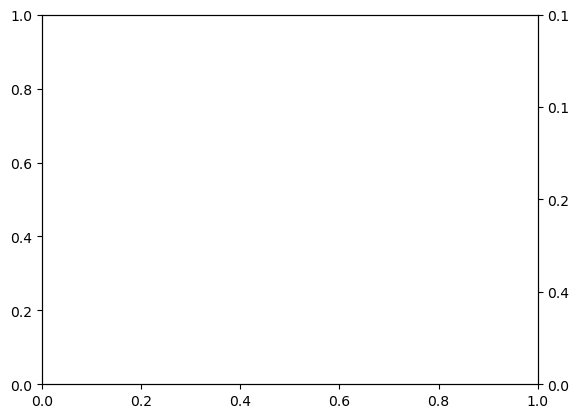

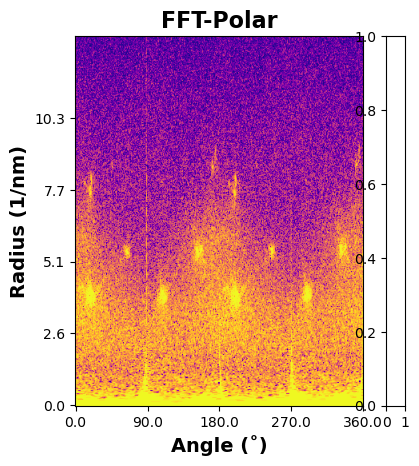

In [615]:
#polar process
path=path_polar
stack=tifffile.imread(path)

nFrames, h,w = stack.shape
scale=35;#px/nm
image=stack[1]

# Rotate the image left by 90 degrees
rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
                           
import matplotlib.ticker as ticker


# Apply contrast enhancement
clahe = cv2.createCLAHE(clipLimit=0.35)
enhanced_image = clahe.apply(rotated_image)

# Apply histogram equalization
equalized_image = cv2.equalizeHist(enhanced_image)

# Define a colormap (e.g., jet)
# # colormap = cv2.COLORMAP_VIRIDIS
# colormap = cv2.COLORMAP_PLASMA
# colormap_image = cv2.applyColorMap(equalized_image, colormap)# colormap_image = plt.get_cmap('fire')(rotated_image / 255.0)
# colormap_image = colormap_image[::-1]

# IO.showFr(colormap_image)

ft=14


d_r=h/scale
d=10/d_r
# plt.xticks(np.arange(0, 360, 4))
# plt.yticks(np.arange(0, h, 2))
#

yticks = np.linspace(0, h, 5)
yticklabels = ['%.1f' % val for val in np.linspace(0, d_r, 5)]




xticks = np.linspace(0, 360, 5)



# Create a twin Axes on the right side
ax2 = plt.twinx()

# Set y-axis tick positions and labels for the second axis
yticklabels_reciprocal = []
for label in yticklabels:
    if float(label) != 0:
        yticklabels_reciprocal.append('%.1f' % (1 / float(label)))
    else:
        yticklabels_reciprocal.append('0.0')
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklabels_reciprocal)




fig, ax1 = plt.subplots()

# plt.plot()
ax1.imshow(equalized_image,cmap='plasma')
ax1.set_ylabel('Radius (1/nm)',fontweight='bold',fontsize=ft)
ax1.set_xlabel('Angle (˚)',fontweight='bold',fontsize=ft)
ax1.set_title('FFT-Polar',fontweight='bold',fontsize=ft+2)

# Set (0,0) coordinate at the left-bottom
ax1.invert_yaxis()

plt.yticks(yticks, yticklabels)
plt.xticks(xticks, xticks)

# Adjust the layout to make room for the colorbar and twin axis
plt.subplots_adjust(right=0.85)



# Add a colorbar
colorbar = plt.colorbar(image, ax=[ax1], location='right', pad=0.05)
colorbar.set_label('Intensity',fontweight='bold',fontsize=ft)

                           
# # Apply the Viridis colormap using Matplotlib
# colormap_image = plt.get_cmap('viridis')(rotated_image / 255.0)

# # Convert the colormap image to BGR format
# colormap_image_bgr = cv2.cvtColor((colormap_image * 255).astype('uint8'), cv2.COLOR_RGB2BGR)


# # Apply the colormap to the image
# colormap_image = cv2.applyColorMap(rotated_image, cv2.COLORMAP_HOT)

